In [1]:
from glob import glob
from src import Module, DataModule, DatasetFCI
import torch 
import torchmetrics 
from tqdm import tqdm
import os 
from skimage import io
import shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
checkpoints = glob('./checkpoints/*')
checkpoints

['./checkpoints/myunet-rs50-fcim-lrs-val_metric=0.68107-epoch=14.ckpt',
 './checkpoints/unetpp-rs50-fcim-lrs-cv-0-val_metric=0.67562-epoch=8.ckpt',
 './checkpoints/unetpp-rs50-fcim-lrs-noval-epoch=29.ckpt',
 './checkpoints/unetpp-rs50-fcim-lrs-cv-4-epoch=29.ckpt',
 './checkpoints/unetpp-rs50-fcim-lrs-cv-2-val_metric=0.69450-epoch=14.ckpt',
 './checkpoints/unetpp-rs50-fcim-lrs-cv-3-epoch=29.ckpt',
 './checkpoints/unetpp-rs50-fcim-lrs-cv-0-epoch=29.ckpt',
 './checkpoints/unetpp-rs50-fcim-lrs-cv-1-val_metric=0.65526-epoch=11.ckpt',
 './checkpoints/unetpp-rs50-fcim-lrs-cv-1-epoch=29.ckpt',
 './checkpoints/unetpp-rs50-fcim-lrs-cv-3-val_metric=0.65155-epoch=10.ckpt',
 './checkpoints/unetpp-rs50-fcim-lrs-cv-2-epoch=29.ckpt',
 './checkpoints/unetpp-rs50-fcim-lrs-val_metric=0.68205-epoch=15.ckpt',
 './checkpoints/unetpp-rs50-fcim-lrs-cv-4-val_metric=0.64039-epoch=8.ckpt']

In [3]:
name = "unetpp-rs50-fcim-lrs-val_metric=0.68205-epoch=15.ckpt"
checkpoint = f'./checkpoints/{name}'

# module = Module.load_from_checkpoint(checkpoint)

state_dict = torch.load(checkpoint, map_location='cpu')['state_dict']
module = Module({"encoder": "timm-resnest50d", "in_chans": 5, "pretrained": None, "padding": 1, "mask_loss": True, "architecture": "UnetPlusPlus"})
module.load_state_dict(state_dict)

<All keys matched successfully>

In [13]:
dm = DataModule(Dataset="DatasetFCIm", batch_size=5)
dm.setup()

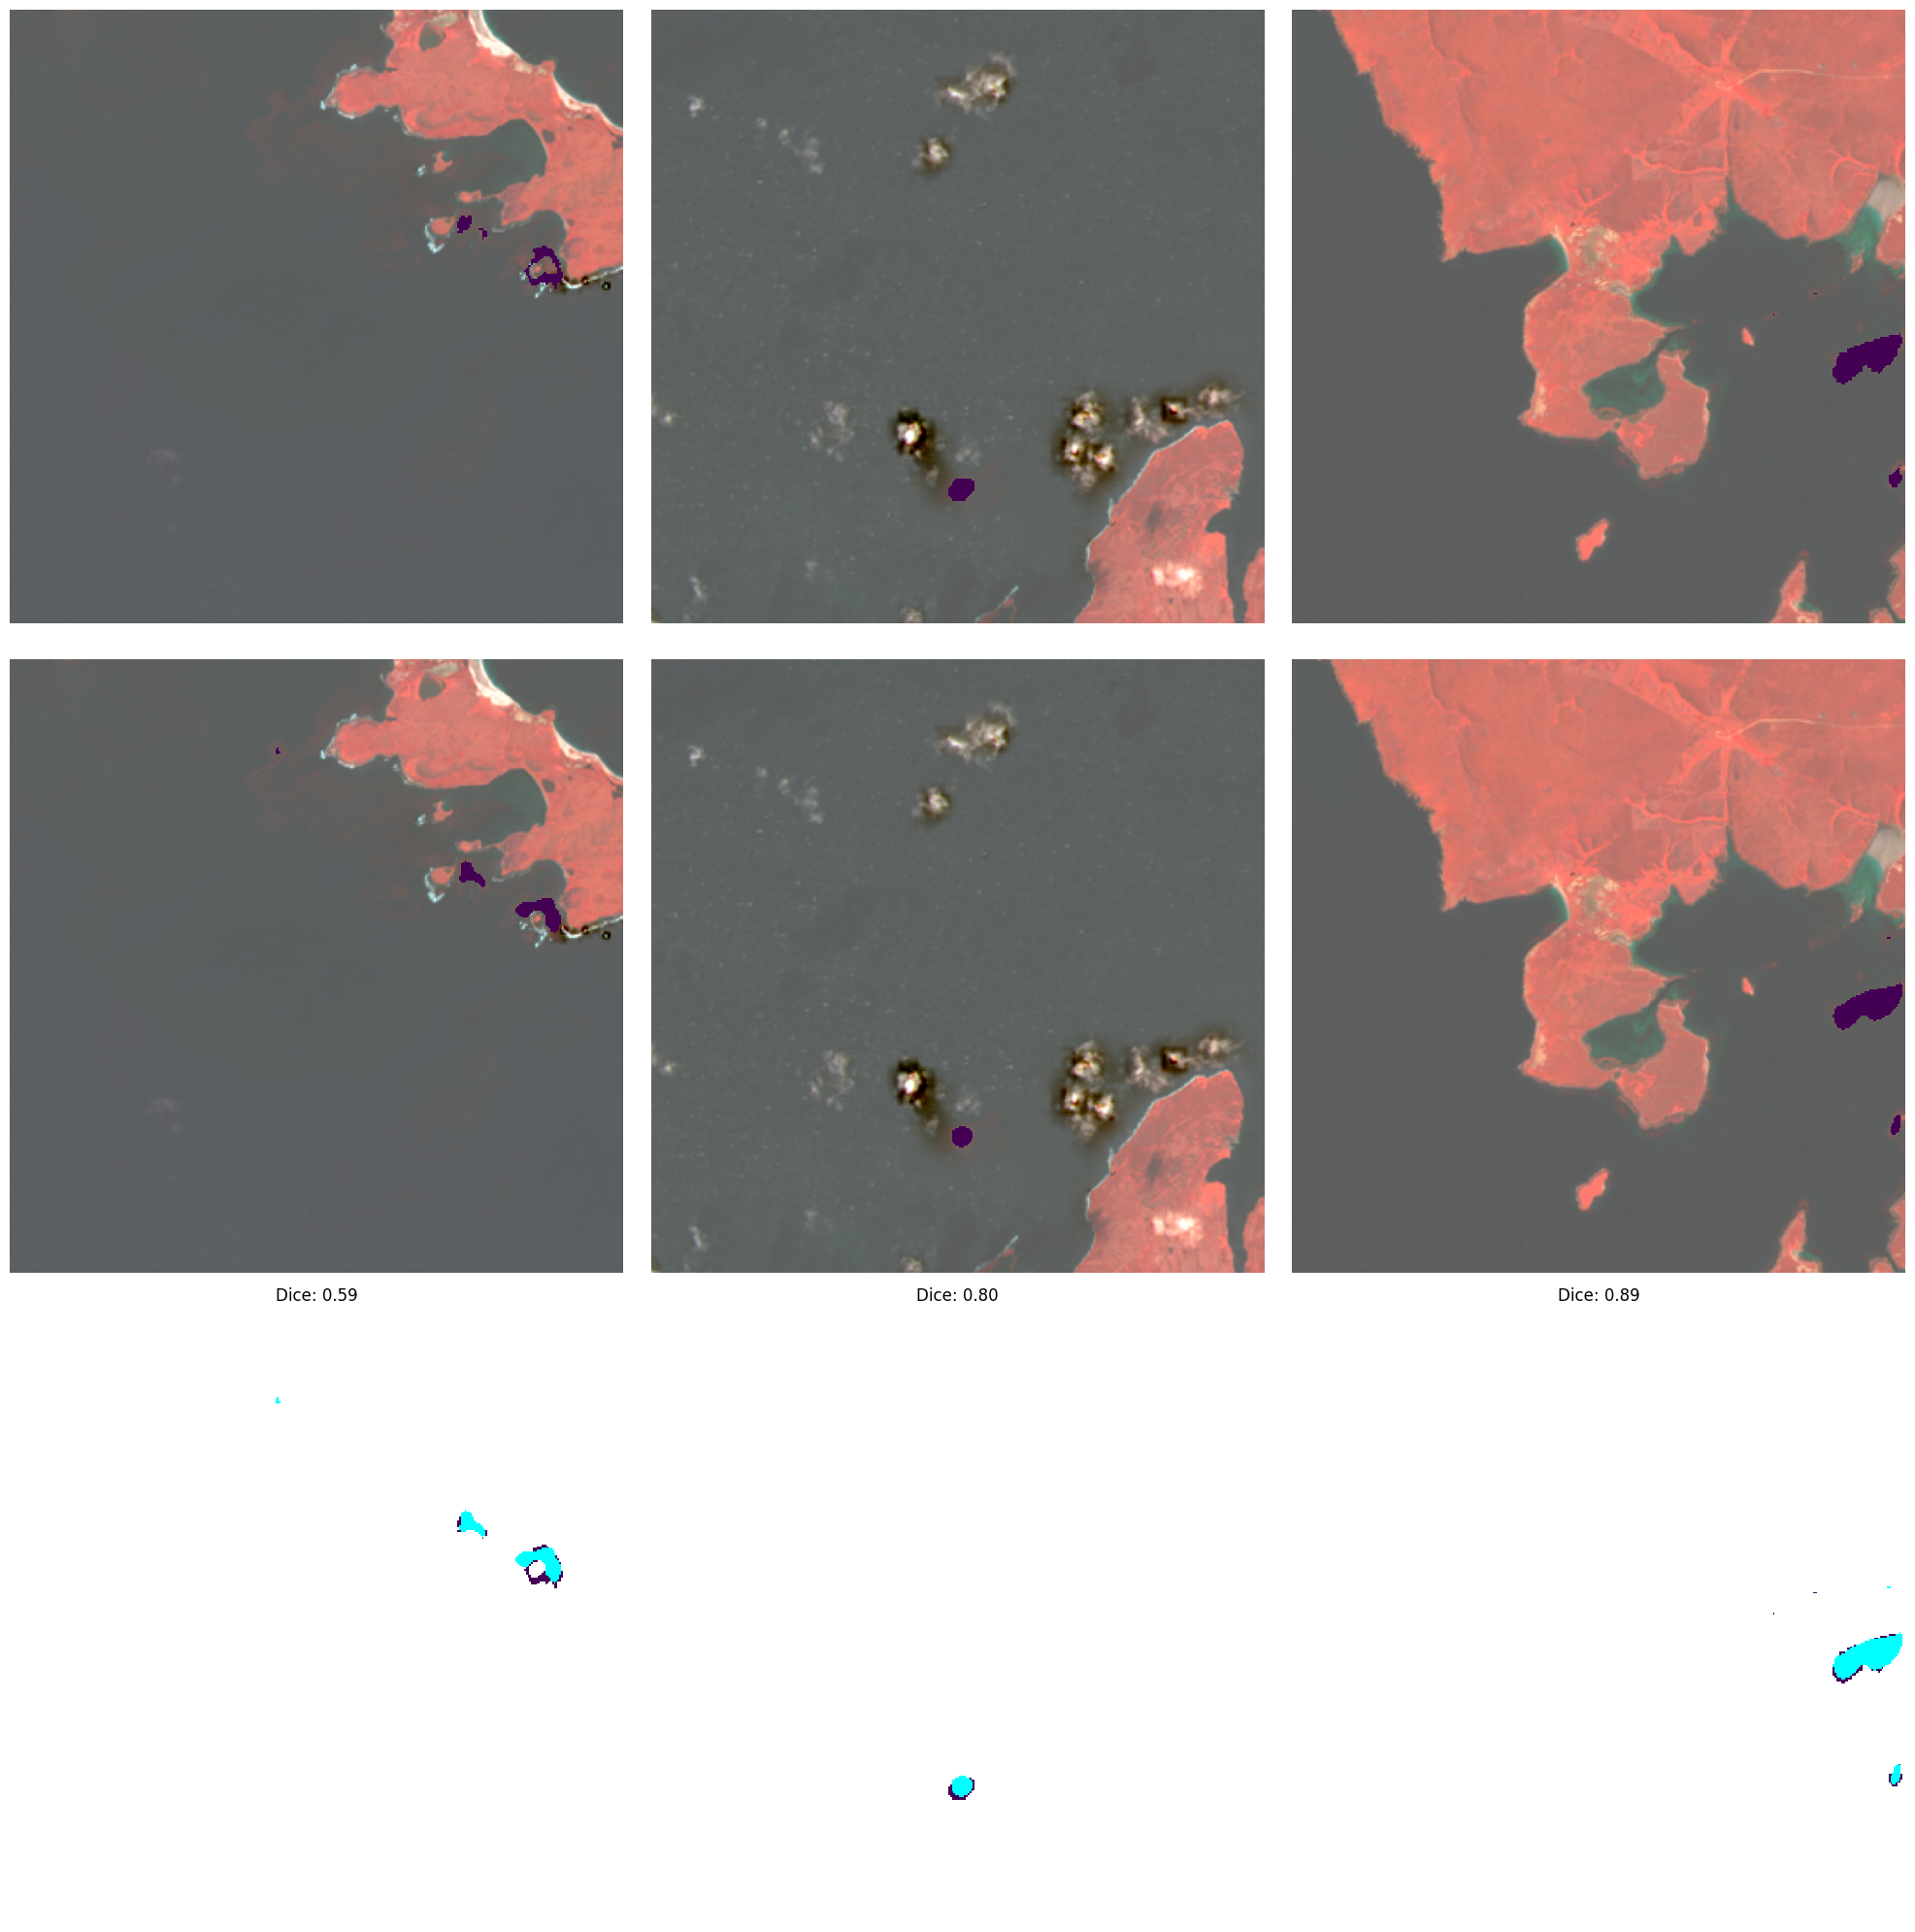

In [26]:
cols, rows = 3, 3  
batch = next(iter(dm.val_dataloader(shuffle=True)))
module.cuda(1)
module.eval()
with torch.no_grad():
	x, y = batch
	x = x[...,:-1]
	y_hat = module(x.cuda(1))
fig, axs = plt.subplots(rows, cols, figsize=(20, 20))  
metric = torchmetrics.Dice().cuda(1)
for col in range(cols):  
	ax = plt.subplot(rows, cols, col + 1) 
	ax.imshow(x[col][...,:3])
	gt = np.ma.masked_where(y[col] < 0.5, y[col])
	ax.imshow(gt)
	ax.axis('off')
	ax = plt.subplot(rows, cols, col + 1 + cols)  
	ax.imshow(x[col][...,:3])
	pred = torch.sigmoid(y_hat[col][0].cpu()) > 0.5
	pred = np.ma.masked_where(pred < 0.5, pred)
	ax.imshow(pred)
	ax.axis('off')
	ax = plt.subplot(rows, cols, col + 1 + cols*2)  
	ax.imshow(gt)
	ax.imshow(pred, cmap='cool')
	ax.axis('off')
	dice = metric(y_hat[col], y[col].cuda(1).unsqueeze(0))
	ax.set_title(f'Dice: {dice.item():.2f}')
plt.tight_layout()
plt.show()

In [21]:
dm = DataModule(Dataset="DatasetFCIm", batch_size=1, val_size=0)
dm.setup()
dm2 = DataModule(Dataset="DatasetFCIm")
dm2.setup()
module.cuda(1)
module.eval()
data = []
for ix, batch in tqdm(enumerate(dm.train_dataloader(shuffle=False)), total=len(dm.train_dataloader())):
	with torch.no_grad():
		x, y, image_id = batch
		x = x[...,:-1]
		y_hat = module(x.cuda(1))
		metric = torchmetrics.Dice().cuda(1)
		dice = metric(y_hat, y.cuda(1).unsqueeze(0))
		preds = torch.sigmoid(y_hat[0].cpu()) > 0.5
	data.append((ix, image_id[0], dice.cpu().item(), (y.sum() > 0).item(), image_id[0] in dm2.val_ds.image_ids))

100%|██████████| 5635/5635 [02:14<00:00, 41.93it/s]


In [65]:
# df = pd.DataFrame(data, columns=["ix", "id", "dice", "mask", "val"])
df = pd.read_csv('data/error_analysis.csv')
# sort by dice
df = df.sort_values(by="dice", ascending=True)
# df.to_csv('data/error_analysis.csv', index=False)
# remove no masks
df = df[df["mask"]]
df

ix        id      dice  mask    val
1752   379  CR843793  0.000000  True  False
1754   224  WT401967  0.000000  True  False
1751   360  OP740084  0.000000  True  False
1759   378  WG619333  0.000000  True  False
1762   388  FV509008  0.000000  True  False
...    ...       ...       ...   ...    ...
5630  3568  LG194336  0.925023  True  False
5631  4891  HK439910  0.928866  True  False
5632  2002  UX371226  0.935117  True  False
5633  2906  SH344312  0.940827  True  False
5634  2454  FK995993  0.946297  True  False

[3526 rows x 5 columns]

In [66]:
df.describe()

ix         dice
count  3526.000000  3526.000000
mean   2790.730573     0.545725
std    1609.022375     0.300598
min       0.000000     0.000000
25%    1396.250000     0.347611
50%    2795.500000     0.666667
75%    4171.750000     0.781260
max    5634.000000     0.946297

In [49]:
df = df[df.dice > 0.3]
df

ix        id      dice  mask    val
2922  4876  ZO476178  0.300469  True  False
2923  1298  YJ673713  0.301887  True  False
2924   659  GX862160  0.302703  True  False
2925  2570  JL108474  0.303393  True  False
2926  5298  HF526156  0.304520  True   True
...    ...       ...       ...   ...    ...
5630  3568  LG194336  0.925023  True  False
5631  4891  HK439910  0.928866  True  False
5632  2002  UX371226  0.935117  True  False
5633  2906  SH344312  0.940827  True  False
5634  2454  FK995993  0.946297  True  False

[2713 rows x 5 columns]

In [101]:
i = 1000

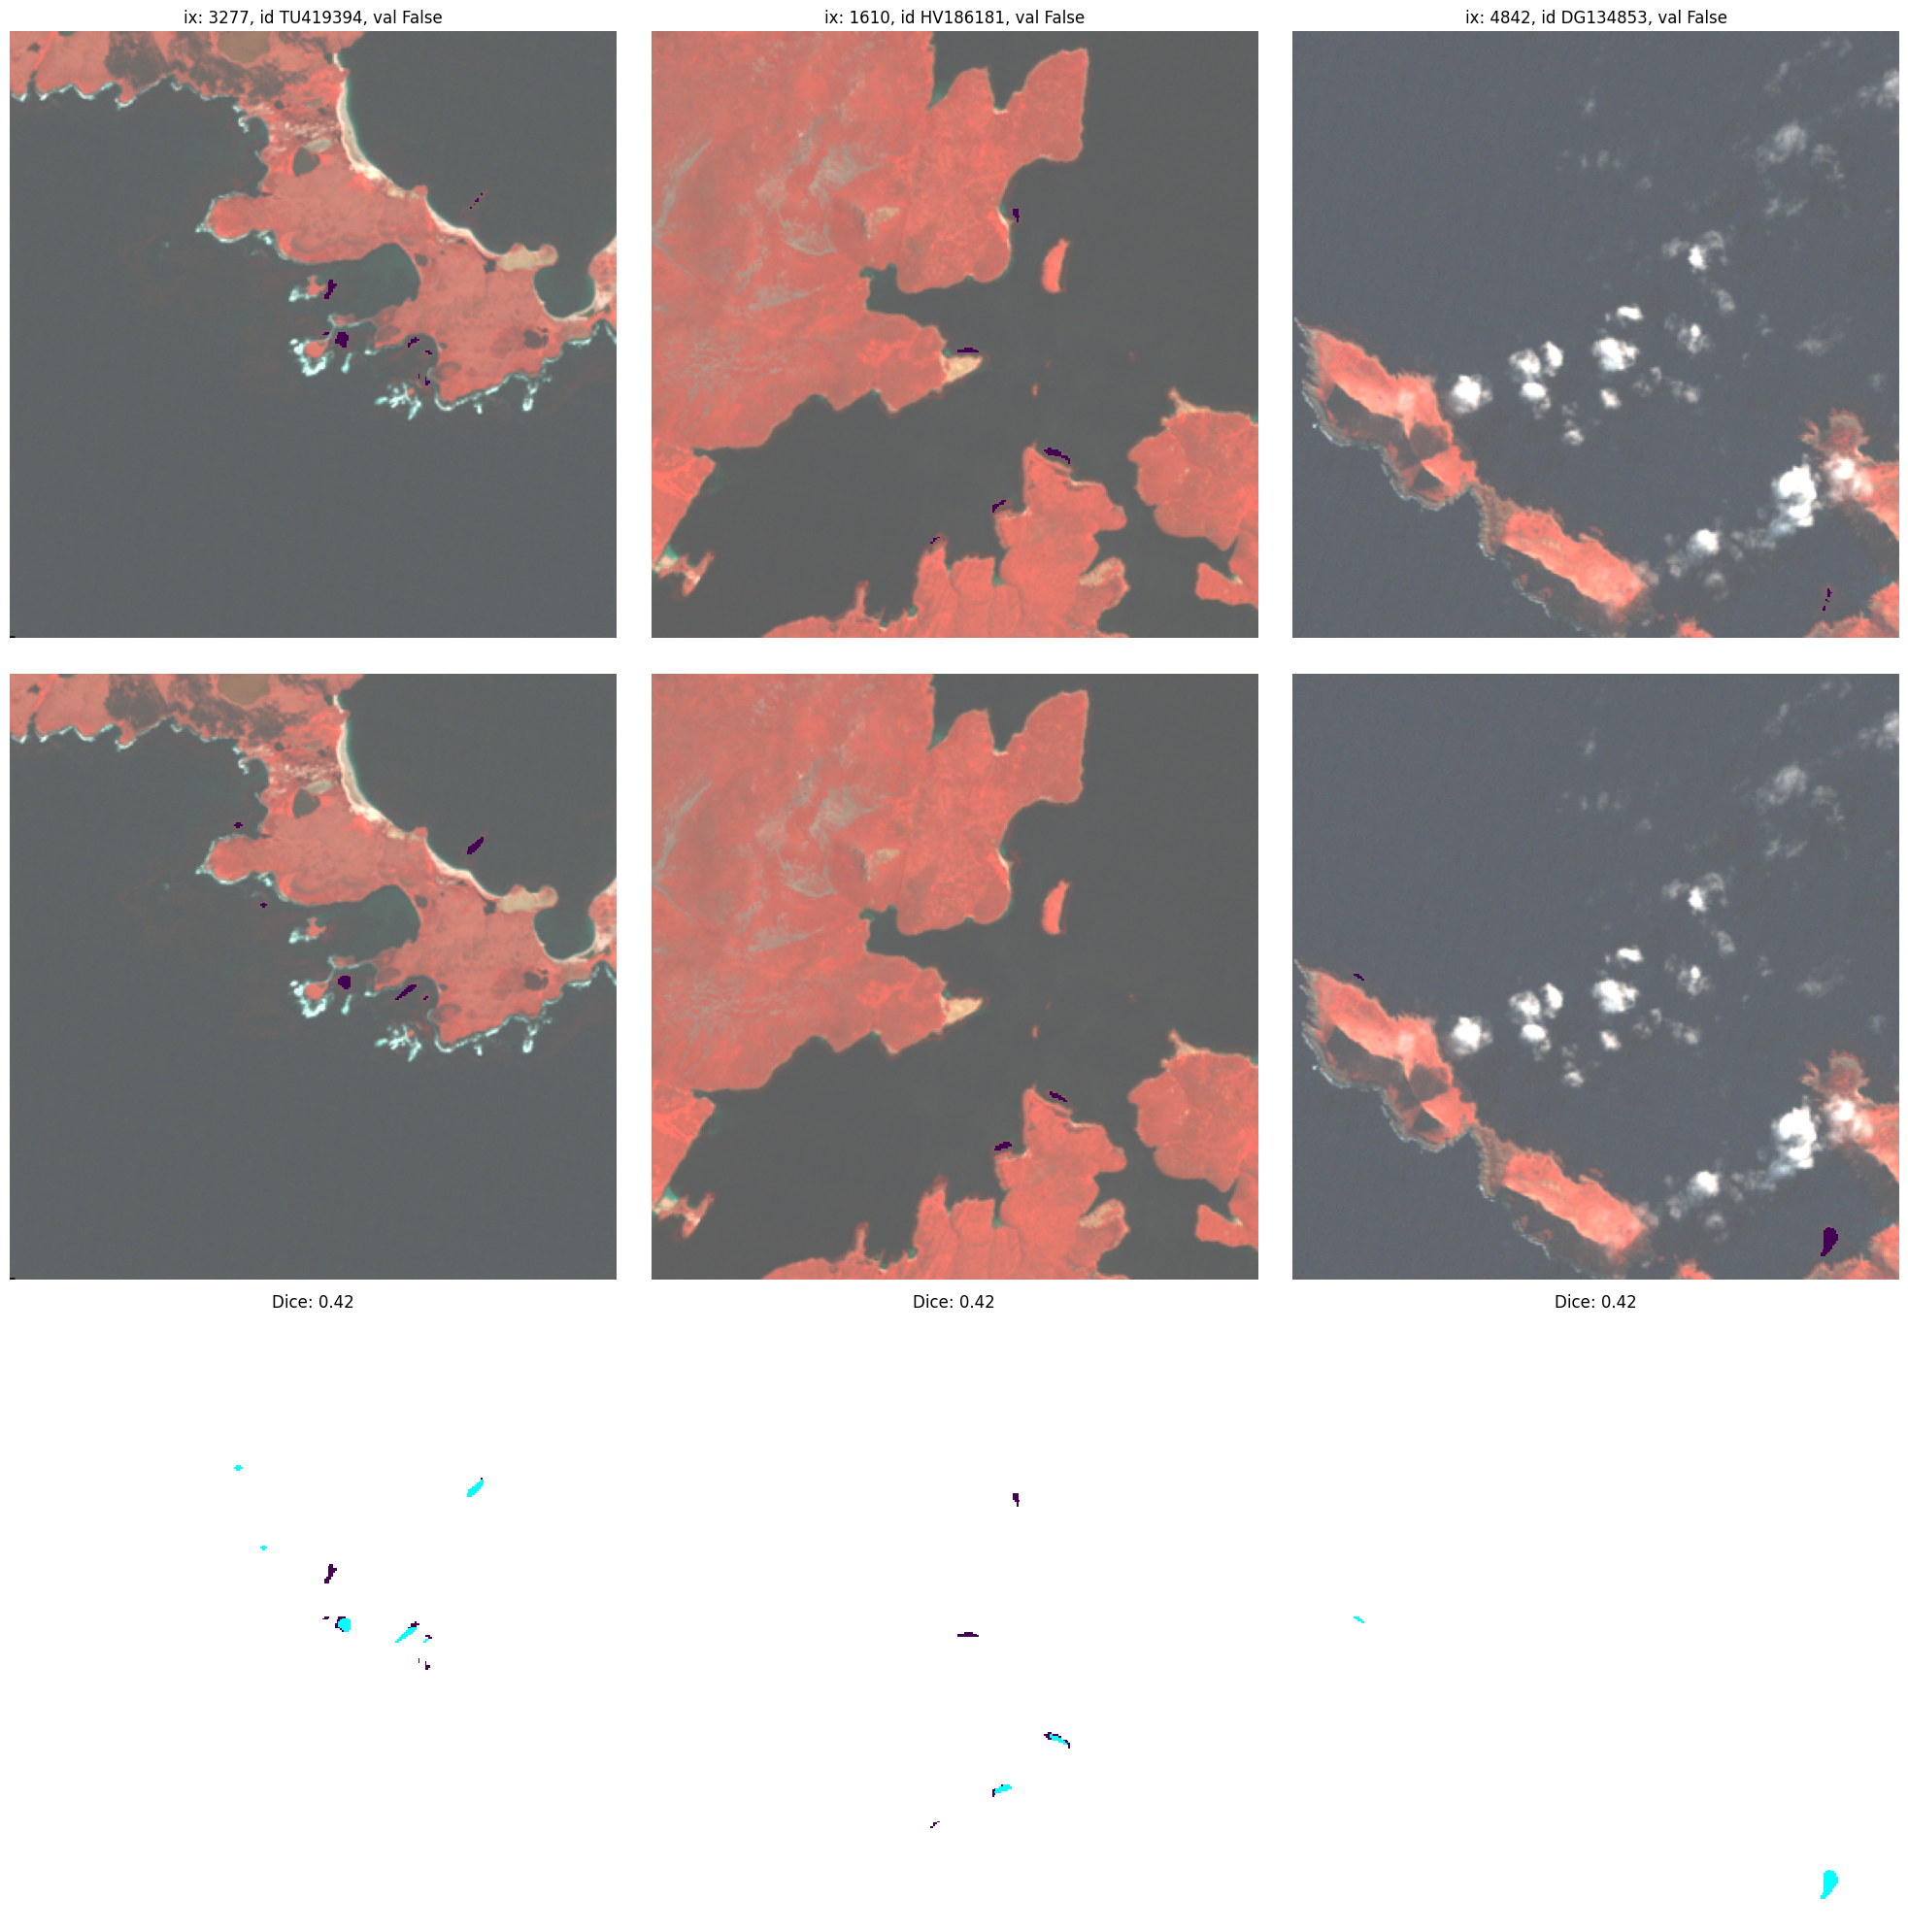

In [102]:
cols, rows = 3, 3  
fig, axs = plt.subplots(rows, cols, figsize=(20, 20))  
for col in range(cols):
	r = df.iloc[col + i]
	# r = df.iloc[len(df) - col - i - 1]
	ix, id = r.ix, r.id
	i += 1
	x, y, _ = dm.train_ds[ix]
	module.cuda(1)
	module.eval()
	with torch.no_grad():
		x = torch.tensor(x[...,:-1])
		y_hat = module(x.cuda(1).unsqueeze(0)).squeeze(0)
	metric = torchmetrics.Dice().cuda(1)
	ax = plt.subplot(rows, cols, col + 1) 
	img = x[...,:3]
	ax.imshow(img)
	gt = np.ma.masked_where(y < 0.5, y)
	ax.imshow(gt)
	ax.axis('off')
	ax.set_title(f'ix: {ix}, id {id}, val {r.val}')
	ax = plt.subplot(rows, cols, col + 1 + cols)  
	ax.imshow(img)
	pred = torch.sigmoid(y_hat[0].cpu()) > 0.5
	pred = np.ma.masked_where(pred < 0.5, pred)
	ax.imshow(pred)
	ax.axis('off')
	ax = plt.subplot(rows, cols, col + 1 + cols*2)  
	ax.imshow(gt)
	ax.imshow(pred, cmap='cool')
	ax.axis('off')
	dice = metric(y_hat, torch.tensor(y).cuda(1).unsqueeze(0))
	ax.set_title(f'Dice: {dice.item():.2f}')
plt.tight_layout()
plt.show()

Puedo ver que hay labels que están mal ! Debería quitarlas del dataset...

Después, el error suele venir en detecciones muuuuy pequeñas. Como mejorar eso? 

In [103]:
df = pd.read_csv('data/error_analysis.csv')
# df = df[(df["mask"] == True) & (df["val"] == False) & (df["dice"] < 0.3)]
df = df[(df["mask"] == True) & (df["dice"] < 0.3)]
df

ix        id      dice  mask    val
3     1911  MO889727  0.000000  True  False
4     4947  JT685253  0.000000  True   True
9     1917  HL173957  0.000000  True  False
12    3358  DN412676  0.000000  True  False
13    3357  OH680822  0.000000  True  False
...    ...       ...       ...   ...    ...
2917  1963  VP535820  0.297309  True  False
2918   404  BF683707  0.297552  True  False
2919  5389  CU610172  0.298052  True  False
2920   840  FF249007  0.298288  True  False
2921  4349  GE603762  0.298319  True  False

[813 rows x 5 columns]

In [104]:
df.id.to_csv('data/ignore.csv', index=False)

In [105]:
ids = pd.read_csv('data/ignore.csv')
ids

id
0    MO889727
1    JT685253
2    HL173957
3    DN412676
4    OH680822
..        ...
808  VP535820
809  BF683707
810  CU610172
811  FF249007
812  GE603762

[813 rows x 1 columns]